In [1]:
import tweepy
import praw
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
import string
from nltk.corpus import stopwords
import datetime
from nltk import punkt
import csv

cache_english_stopwords=stopwords.words('english')

sid = SentimentIntensityAnalyzer()

def text_clean(tweet, redd):
    if not redd:
        # Remove tickers
        sent_no_tickers=re.sub(r'\$\w*','',tweet)
    
        tw_tknzr=TweetTokenizer(strip_handles=True, reduce_len=True)
        temp_tw_list = tw_tknzr.tokenize(sent_no_tickers)
    else:
        temp_tw_list = word_tokenize(submission.title)
        
     # Remove hyperlinks
    list_no_hyperlinks=[re.sub(r'https?:\/\/.*\/\w*','',i) for i in temp_tw_list]
    
    # Remove hashtags
    list_no_hashtags=[re.sub(r'#', '', i) for i in list_no_hyperlinks]
 
    # Remove Punctuation and split 's, 't, 've with a space for filter
    list_no_punctuation=[re.sub(r'['+string.punctuation+']+', ' ', i) for i in list_no_hashtags]
    
     #remove non alpha numeric
    list_no_back=[re.sub(r'[\W_]+', '', i) for i in list_no_punctuation]
    
    # Remove stopwords
    list_no_stopwords=[i for i in list_no_back if i.lower() not in     cache_english_stopwords]
    
    #remove btc stopwords
    btc_stop = {'btc', 'bitcoin', 'eth', 'crypto', 'curreny', 'bitcoinnews',
                'ethereum', 'altcoins', 'cryptolife', 'cryptocurrency', 'blockchain',
               'bitcoins', 'coinbase','litecoin', 'cryptocurrencies', 'https', '...'}
    
    list_no_btc=[i for i in list_no_stopwords if not i.lower() in btc_stop]
   
    # Remove multiple whitespace
    new_sent = ' '.join(list_no_btc)
    # Remove any words with 2 or fewer letters
    if not redd:
        filtered_list = tw_tknzr.tokenize(new_sent)
    else:
        filtered_list = word_tokenize(new_sent)
    list_filtered = [re.sub(r'^\w\w?$', '', i) for i in filtered_list]
  
    filtered_sent =' '.join(list_filtered)
    clean_sent=re.sub(r'\s\s+', ' ', filtered_sent)
    #Remove any whitespace at the front of the sentence
    clean_sent=clean_sent.lstrip(' ')
   
    return clean_sent

In [2]:
consumer_token = '4xziFsP5CtGK90qo5WUV3SaJV'
consumer_secret = 'be7Px0TrzsxCcxiK99NHovB5oKeBdO8n0LCYFUIEnPZ8249Gwo'
access_token = '826508817416462341-YTG7DahNC8zxeroS97jl2DjhRBJeUdl'
access_secret = 'Kxhjy9f2aB5wFnnUVmcGykZKlIXEN3R4dX57bQizX7krU'


auth = tweepy.OAuthHandler(consumer_token, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

search_text = '#bitcoin'

all_tweets = []

public = tweepy.Cursor(api.search, q=search_text, lang='en', tweet_mode='extended').items(200)
for tweet in public:
    
    parsed = []
    parsed.append(text_clean(tweet.full_text, False))
    parsed.append(sid.polarity_scores(parsed[0])['neg'])
    parsed.append(sid.polarity_scores(parsed[0])['neu'])
    parsed.append(sid.polarity_scores(parsed[0])['pos'])
    parsed.append(sid.polarity_scores(parsed[0])['compound'])
    parsed.append(tweet.created_at.strftime('%m/%d/%Y %H:%M:%S'))
    parsed.append(tweet.retweet_count)
    parsed.append(tweet.favorite_count)
    parsed.append(tweet.id_str)
    
    all_tweets.append(parsed)


row_name = ['text', 'neg', 'neu', 'pos', 'compund', 'time', 'retweet', 'fav', 'id']

with open('tweet.csv', 'ab+') as csvfile:
    write = csv.writer(csvfile)
    #write.writerow(row_name)
    
    for row in all_tweets:
        try:
            write.writerow(row)
        except:
            print 'skipping'

In [3]:
client_id = '8_US9I43O5unJA'
client_sec = 'onShy20mNJUYjGUiJmzBiq0cWAc'
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.167 Safari/537.36'

reddit = praw.Reddit(client_id=client_id, client_secret=client_sec, user_agent=user_agent)
bitcoin_sub = reddit.subreddit('Bitcoin').submissions(1519819200, 1520502000)

submissions = []

for submission in bitcoin_sub:
    
    row = []
    
    row.append(text_clean(submission.title, True))
    row.append(sid.polarity_scores(text_clean(submission.title, True))['neg'])
    row.append(sid.polarity_scores(text_clean(submission.title, True))['neu'])
    row.append(sid.polarity_scores(text_clean(submission.title, True))['pos'])
    row.append(sid.polarity_scores(text_clean(submission.title, True))['compound'])
    row.append(submission.score)
    row.append(submission.gilded)
    row.append(datetime.datetime.fromtimestamp(submission.created).strftime('%m/%d/%Y %H:%M:%S'))
                              
    submissions.append(row)
    
    
row_name = ['text', 'neg', 'neu', 'pos', 'compund', 'score', 'golds', 'time']
    
with open('reddit.csv', 'wb') as csvfile:
    write = csv.writer(csvfile)
    write.writerow(row_name)
    
    for row in submissions:
        try:
            write.writerow(row)
        except:
            print 'skipping'
            

In [4]:
#### Cleaning up CSV data and average calculation for prices by hour#####
import pandas as pd
phour = pd.read_csv('C:\Users\Mishuk\Notebooks\\finalized_data.csv')
phour['Time'] = pd.to_datetime(phour['Time'])
phour.insert(0,'date', phour['Time'].dt.date)
phour.insert(1,'time', phour['Time'].dt.time)
phour.drop('Time', axis=1, inplace=True)
phour.insert(2,'average',(phour['bitfinex']+phour['bitstamp']+phour['cex.io']+phour['coinbase']+
            phour['exmo']+phour['gemini']+phour['hitbtc']+phour['itbit']+phour['kraken']+phour['others'])/10)

In [5]:
%matplotlib inline
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
rd = pd.read_csv('C:\Users\Mishuk\Notebooks\\reddit.csv')
tw = pd.read_csv('C:\Users\Mishuk\Notebooks\\tweet.csv')

rd['time'] = pd.to_datetime(rd['time'])
tw['time'] = pd.to_datetime(tw['time'])
## seperate date and time
tw.insert(5,'date', tw['time'].dt.date)
tw['time'] = tw['time'].dt.time

rd.insert(5,'date', rd['time'].dt.date)
rd['time'] = rd['time'].dt.time
#remove all posts with no sentiment
rd = rd[rd.compund != 0]
tw = tw[tw.compund != 0]
x = np.arange(0,24,1)



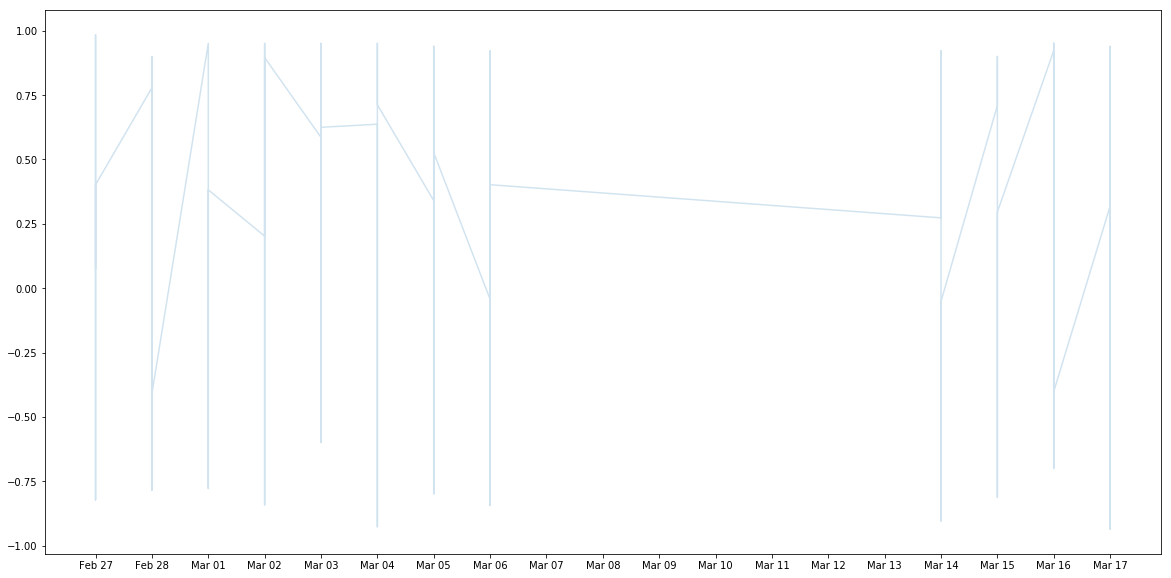

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot_date(tw['date'], tw['compund'], alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

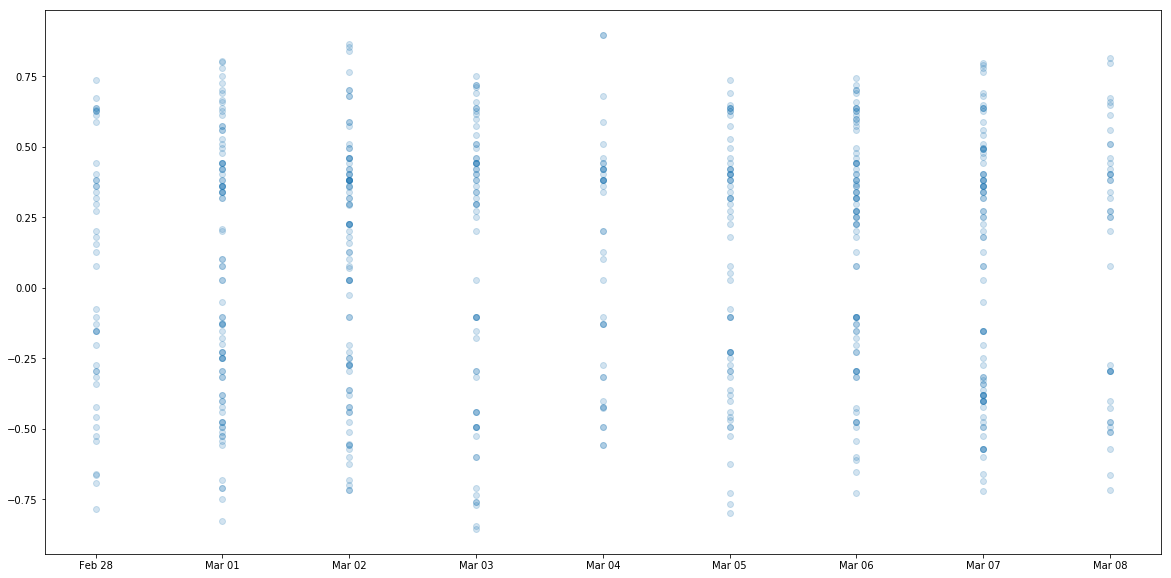

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot_date(rd['date'], rd['compund'], alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [8]:
from datetime import datetime
import matplotlib.dates as mdates
focused_dates27 = datetime.strptime('2018-02-27', '%Y-%m-%d').date()
focused_dates28 = datetime.strptime('2018-02-28', '%Y-%m-%d').date()
focused_dates01 = datetime.strptime('2018-03-01', '%Y-%m-%d').date()
focused_dates02 = datetime.strptime('2018-03-02', '%Y-%m-%d').date()
focused_dates03 = datetime.strptime('2018-03-03', '%Y-%m-%d').date()
focused_dates04 = datetime.strptime('2018-03-04', '%Y-%m-%d').date()
focused_dates05 = datetime.strptime('2018-03-05', '%Y-%m-%d').date()
focused_dates06 = datetime.strptime('2018-03-06', '%Y-%m-%d').date()
focused_dates07 = datetime.strptime('2018-03-07', '%Y-%m-%d').date()
focused_dates08 = datetime.strptime('2018-03-08', '%Y-%m-%d').date()
focused_dates09 = datetime.strptime('2018-03-09', '%Y-%m-%d').date()
focus =[focused_dates27,focused_dates28,focused_dates01,focused_dates02,
       focused_dates03,focused_dates04,focused_dates05,focused_dates06,
       focused_dates07,focused_dates08,focused_dates09]

btc27 = phour[phour.date == focused_dates27]
btc28 = phour[phour.date == focused_dates28]
btc01 = phour[phour.date == focused_dates01]
btc02 = phour[phour.date == focused_dates02]
btc03 = phour[phour.date == focused_dates03]
btc04 = phour[phour.date == focused_dates04]
btc05 = phour[phour.date == focused_dates05]
btc06 = phour[phour.date == focused_dates06]
btc07 = phour[phour.date == focused_dates07]
btc08 = phour[phour.date == focused_dates08]
btc09 = phour[phour.date == focused_dates09]



[Text(0.5,1,u'Reddit')]

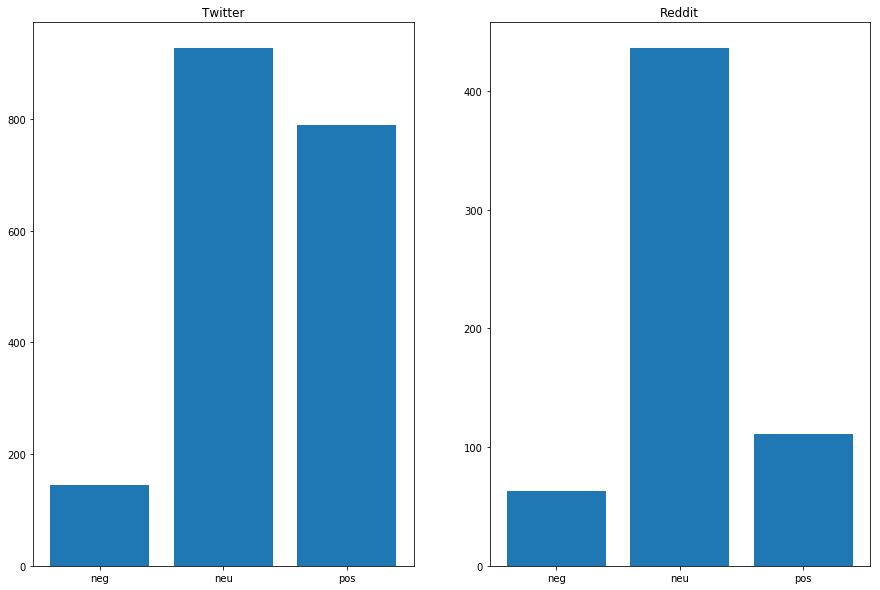

In [9]:
pos_tw = tw.compund[tw.compund >= .5].count()
neg_tw = tw.compund[tw.compund <= -0.5].count()
neu_tw = tw.compund.count() - neg_tw - pos_tw

pos_rd = rd.compund[rd.compund >= .5].count()
neg_rd = rd.compund[rd.compund <= -.5].count()
neu_rd = rd.compund.count() - neg_rd - pos_rd

counts_tw = [pos_tw, neg_tw, neu_tw]
counts_rd = [pos_rd, neg_rd, neu_rd]
senti = ['pos', 'neg', 'neu']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.bar(senti, counts_tw)
ax1.set(title='Twitter')
ax2.bar(senti, counts_rd)
ax2.set(title='Reddit')

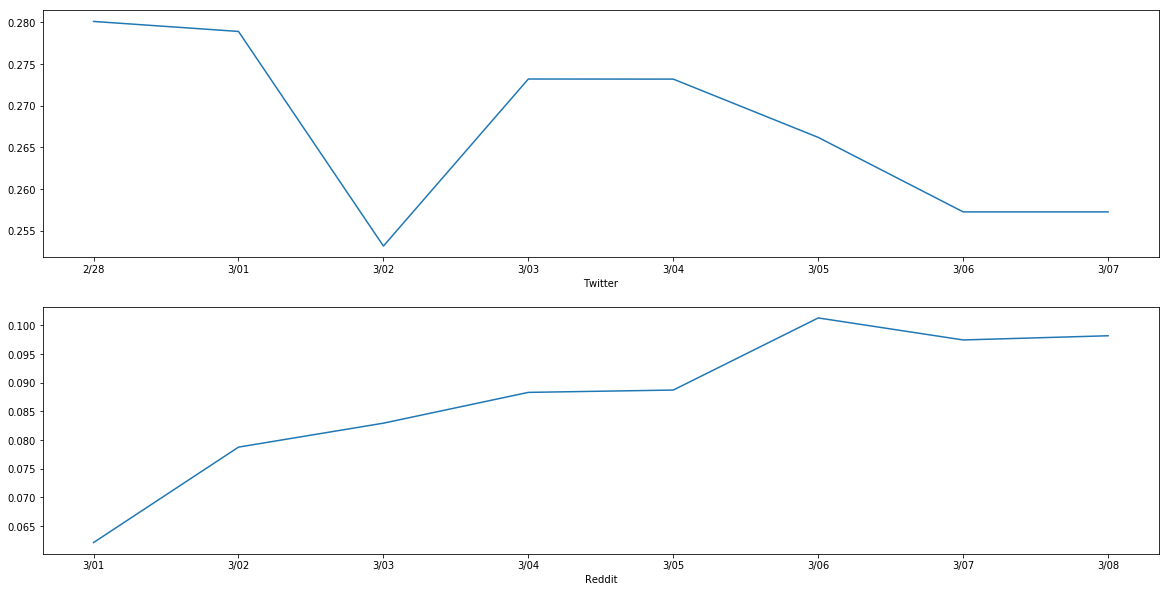

In [10]:
day_avg = []
rd_avg = []

i=['2/28','3/01', '3/02', '3/03', '3/04', '3/05', '3/06', '3/07']
j=['3/01', '3/02', '3/03', '3/04', '3/05', '3/06', '3/07', '3/08']
for item in i:
    day_avg.append(tw.compund[tw.date <= datetime.strptime(item + '/2018','%m/%d/%Y').date()].mean())
for item in j:   
    rd_avg.append(rd.compund[rd.date <= datetime.strptime(item + '/2018','%m/%d/%Y').date()].mean())
    
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(20,10))
ax.plot(i, day_avg)
ax.set_xlabel('Twitter')
ax2.plot(j, rd_avg)
ax2.set_xlabel('Reddit')
plt.show()


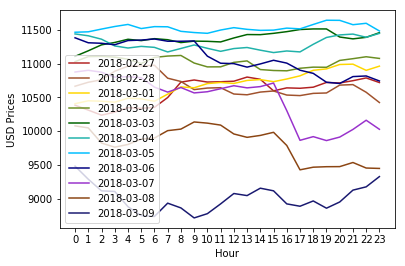

In [11]:
############### BTC HOURLY PRICES ########################### 

x = np.arange(0,24,1)
#x = btc27['time']
fig, ax = plt.subplots()

ax.plot(x,btc27['average'],color ='firebrick')
ax.plot(x,btc28['average'],color ='sienna')
ax.plot(x,btc01['average'],color ='gold')
ax.plot(x,btc02['average'],color ='olivedrab')
ax.plot(x,btc03['average'],color ='darkgreen')
ax.plot(x,btc04['average'],color ='lightseagreen')
ax.plot(x,btc05['average'],color ='deepskyblue')
ax.plot(x,btc06['average'],color ='navy')
ax.plot(x,btc07['average'],color ='darkorchid')
ax.plot(x,btc08['average'],color ='saddlebrown')
ax.plot(x,btc09['average'],color ='midnightblue')
plt.xticks(np.arange(0, 24, 1.0))

plt.rcParams['figure.figsize'] = 20, 10
plt.legend(focus)
plt.xlabel('Hour')
plt.ylabel('USD Prices')
plt.show()

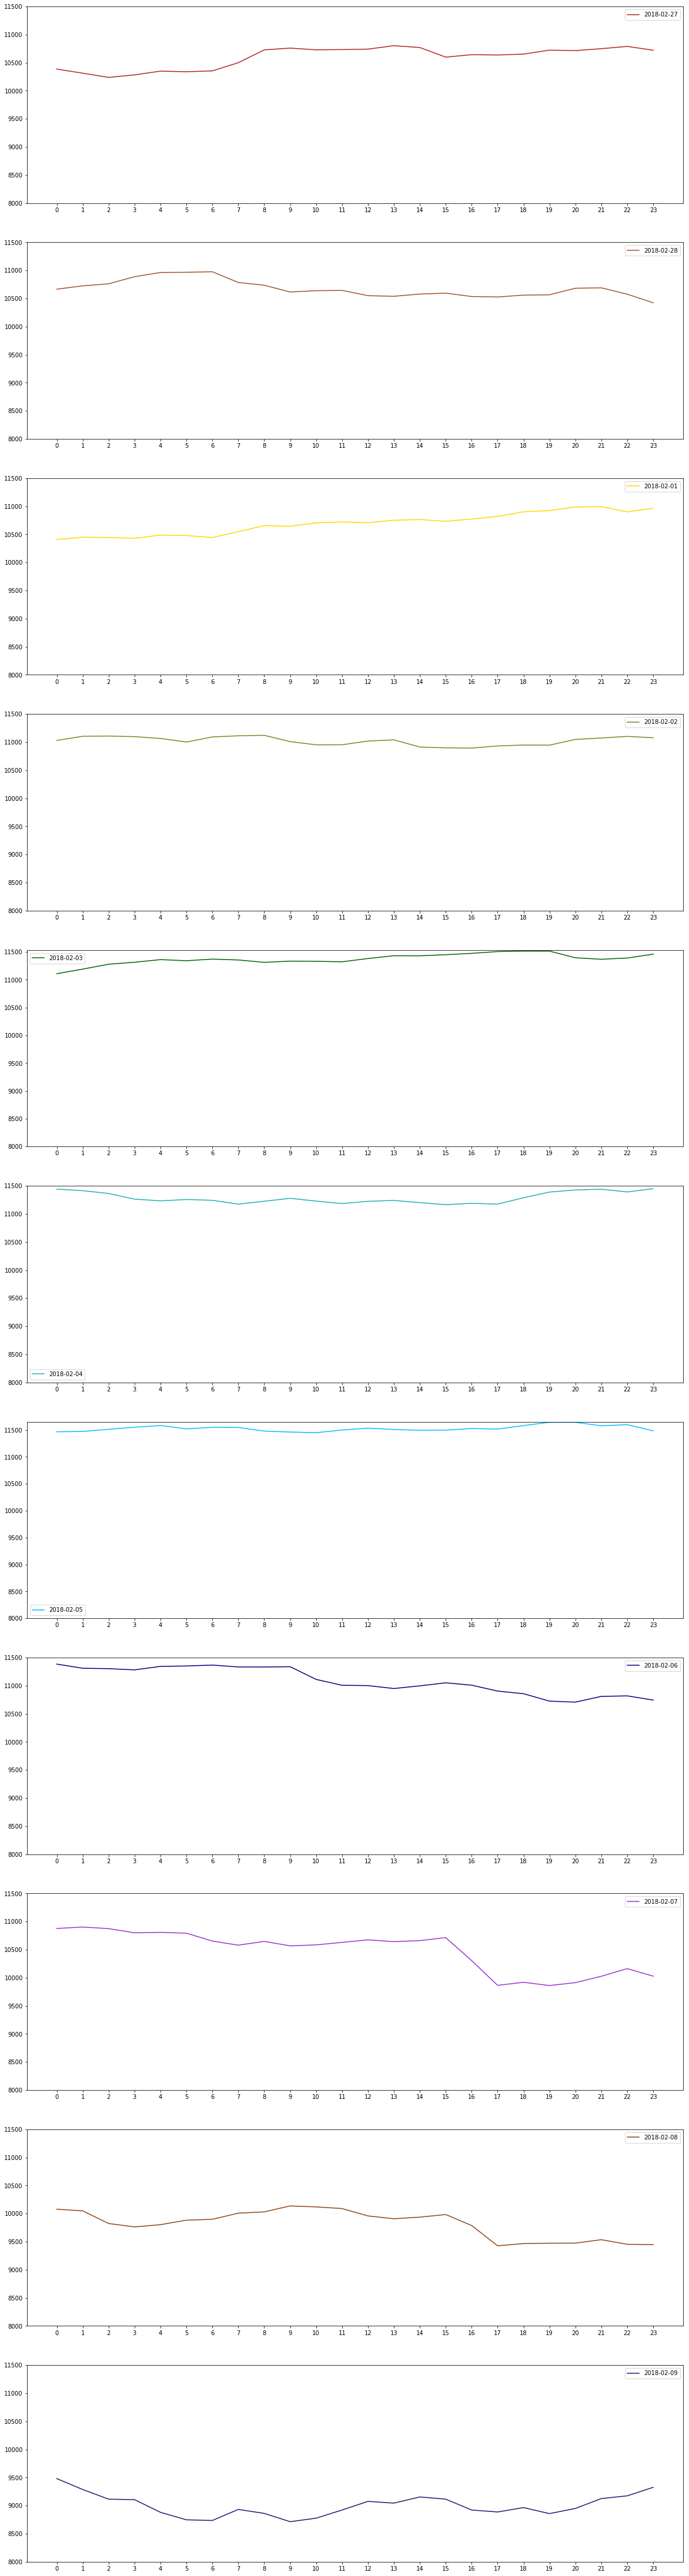

In [12]:
############individual Graphs ####################
y = np.arange(8000,max(phour['average']),500)
fig, (ax27, ax28,ax01,ax02,ax03,ax04,ax05,ax06,ax07,ax08,ax09) = plt.subplots(11, 1, figsize=(20,80))
ax27.plot(x,btc27['average'],label='2018-02-27',color ='firebrick');
ax28.plot(x,btc28['average'],label='2018-02-28',color ='sienna'); 
ax01.plot(x,btc01['average'],label='2018-02-01',color ='gold'); 
ax02.plot(x,btc02['average'],label='2018-02-02',color ='olivedrab'); 
ax03.plot(x,btc03['average'],label='2018-02-03',color ='darkgreen'); 
ax04.plot(x,btc04['average'],label='2018-02-04',color ='lightseagreen'); 
ax05.plot(x,btc05['average'],label='2018-02-05',color ='deepskyblue'); 
ax06.plot(x,btc06['average'],label='2018-02-06',color ='navy'); 
ax07.plot(x,btc07['average'],label='2018-02-07',color ='darkorchid'); 
ax08.plot(x,btc08['average'],label='2018-02-08',color ='saddlebrown'); 
ax09.plot(x,btc09['average'],label='2018-02-09',color ='midnightblue'); 

## note: Un-comment the yticks for a more stable line pattern
##
ax27.legend();ax27.set_xticks(x, minor=False);ax27.set_yticks(y, minor=False);
ax28.legend();ax28.set_xticks(x, minor=False);ax28.set_yticks(y, minor=False);
ax01.legend();ax01.set_xticks(x, minor=False);ax01.set_yticks(y, minor=False);
ax02.legend();ax02.set_xticks(x, minor=False);ax02.set_yticks(y, minor=False);
ax03.legend();ax03.set_xticks(x, minor=False);ax03.set_yticks(y, minor=False);
ax04.legend();ax04.set_xticks(x, minor=False);ax04.set_yticks(y, minor=False);
ax05.legend();ax05.set_xticks(x, minor=False);ax05.set_yticks(y, minor=False);
ax06.legend();ax06.set_xticks(x, minor=False);ax06.set_yticks(y, minor=False);
ax07.legend();ax07.set_xticks(x, minor=False);ax07.set_yticks(y, minor=False);
ax08.legend();ax08.set_xticks(x, minor=False);ax08.set_yticks(y, minor=False);
ax09.legend();ax09.set_xticks(x, minor=False);ax09.set_yticks(y, minor=False);

plt.show()


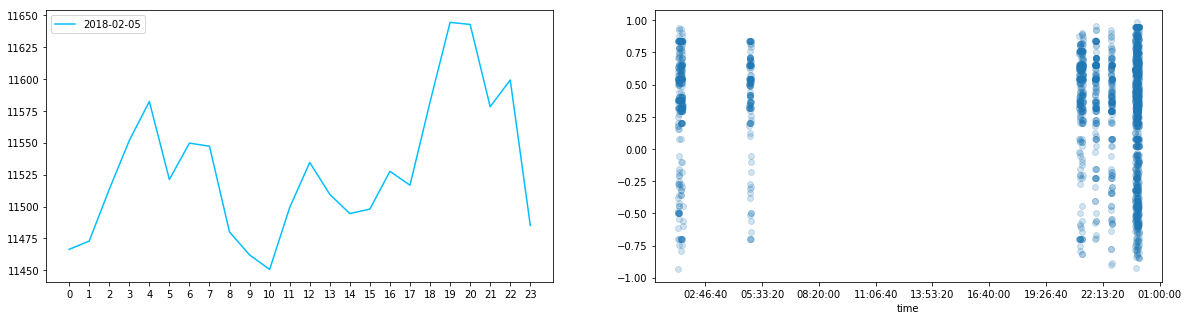

In [60]:
fig, (ax05,ax06) = plt.subplots(1,2,figsize=(20,5))
ax05.plot(x,btc05['average'],label='2018-02-05',color ='deepskyblue'); 
ax05.legend();ax05.set_xticks(x, minor=False)
tw_dates05 = datetime.strptime('2018-02-27', '%Y-%m-%d').date() 
tw05 = tw[tw.date == tw_dates05]
ax06.plot_date(tw['time'],tw['compund'],label='2018-02-05',alpha =0.2);

plt.show()